In [1]:
# %load ../start.py
# Imports
import os
import sys
import yaml
from pathlib import Path
import re

from joblib import Memory
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../../lib/python')
from s2rnai.notebook import Nb

# Setup notebook
nbconfig = Nb.setup_notebook()

# Turn on cache
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Set up references
with open('../../config/config.yml') as fh:
    config = yaml.load(fh)

assembly = config['assembly']
tag = config['aligner']['tag']
REF = Path(os.environ['REFERENCES_DIR'], assembly, tag)


last updated: 2017-11-28 
Git hash: 7e28eeb5f590f9d8546a93b6d7ae1340f5dd5df8


In [2]:
# Get annotation info
fbgn2symbol = pd.read_csv(REF/'fb_annotation/dmel_r6-16.fb_annotation', sep='\t', index_col=1)['gene_symbol'].to_dict()
symbol2fbgn = {v: k for k, v in fbgn2symbol.items()}

In [3]:
# get sample metadata
stable = pd.read_csv('../../config/sampletable.tsv', sep='\t')
srrs = stable.samplename.unique().tolist()
lacz = stable[stable.target_symbol == 'LacZ'].samplename.unique().tolist()
drsc = stable[stable.target_symbol != 'LacZ'].samplename.unique().tolist()

len(srrs), len(lacz), len(drsc)

(1900, 20, 1880)

In [4]:
# imports drsc adjusted counts tables
dfs = []
pattern = '../../rnaseq-wf/data/rnaseq_samples/{srr}/{srr}.cutadapt.bam.drsc.counts'
for srr in drsc:
    fname = pattern.format(srr=srr)
    if os.path.exists(fname):
        dfs.append(pd.read_table(fname))

adjusted_cnts = pd.concat(dfs, ignore_index=True)

In [5]:
# imports feature counts
@memory.cache
def get_featurecounts():
    dfs = []
    pattern = '../../rnaseq-wf/data/rnaseq_samples/{srr}/{srr}.cutadapt.bam.featurecounts.txt'
    for srr in srrs:
        fname = pattern.format(srr=srr)
        if os.path.exists(fname):
            dfs.append(pd.read_table(fname, sep='\t', comment='#').iloc[:, [0, -1]].set_index('Geneid'))

    cnts = pd.concat(dfs, axis=1)
    cnts.columns = [re.findall(r'SRR\d+', x)[-1] for x in cnts.columns]
    cnts.sort_index(inplace=True)
    return cnts

cnts = get_featurecounts()

In [6]:
cnts.head()

SRR3486891  SRR3486986  SRR3487576  SRR3487481  SRR3486819  \
Geneid                                                                    
FBgn0000003           0           0           2           0           0   
FBgn0000008          14           4          29          32          52   
FBgn0000014           0           0           1           0           0   
FBgn0000015           0           0           0           0           0   
FBgn0000017        2045         433        3026        3817        4080   

             SRR3486724  SRR3488246  SRR3488341  SRR3488418  SRR3486708  \
Geneid                                                                    
FBgn0000003           0           0           0           0           0   
FBgn0000008          23          71          49          55          23   
FBgn0000014           0           4           0           0           1   
FBgn0000015           0           2           0           1           0   
FBgn0000017        2082        4807        3092        3276        1679   

                ...      SRR3488216  SRR3488311  SRR3488150  SRR3488055  \
Geneid          ...                                                       
FBgn0000003     ...               0           0           0           0   
FBgn0000008     ...              14          44          56           0   
FBgn0000014     ...               3           1           2           0   
FBgn0000015     ...               0           0           1           0   
FBgn0000017     ...            1131        3254        3956           2   

             SRR3487463  SRR3487558  SRR3488170  SRR3488265  SRR3488306  \
Geneid                                                                    
FBgn0000003           1           2           0           0           0   
FBgn0000008          39          18          79          20          26   
FBgn0000014           0           0           0           1           0   
FBgn0000015           3           1           3           0           0   
FBgn0000017        3866        3158        4374        1740        2557   

             SRR3488211  
Geneid                   
FBgn0000003           0  
FBgn0000008          38  
FBgn0000014           0  
FBgn0000015           4  
FBgn0000017        3670  

[5 rows x 1900 columns]

In [7]:
lacz_median_cnts = cnts.loc[:, lacz].median(axis=1)

In [8]:
def plot(fbgn, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    symbol = fbgn2symbol[fbgn]
    drscs = stable.loc[stable.target_FBgn == fbgn, ['samplename', 'drsc_rep']]
    _A = np.log10(lacz_median_cnts + 1)
    _B = np.log10(cnts[drscs.samplename].median(axis=1) + 1)
    ax.scatter(_A, _B, s=5, c='k')
    for _, row in drscs.iterrows():
        if row.drsc_rep == 1:
            color = 'r'
        else:
            color = 'c'
        _B = np.log10(cnts[row.samplename] + 1)
        ax.scatter(_A[fbgn], _B[fbgn], s=30, c=color)
        
    ax.set_title(fbgn)
        
    return plt.gcf()

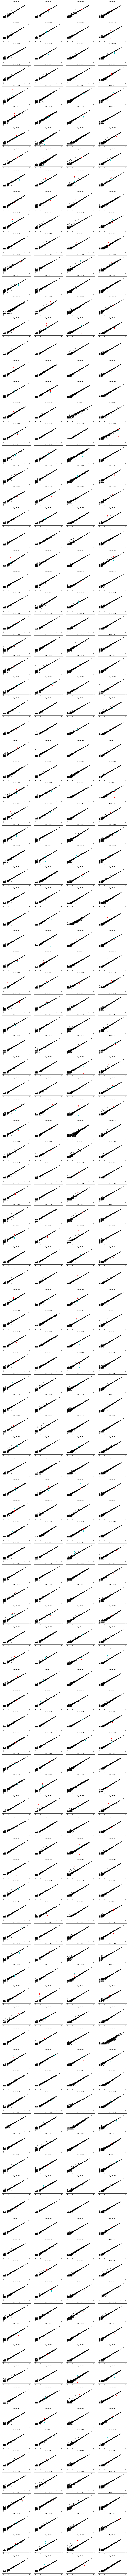

In [10]:
fig, axes = plt.subplots(122, 4, figsize=(20, 400))
targets = [x for x in stable.target_FBgn.unique() if x != 'FBgnNA']
for fbgn, ax in zip(targets, axes.flatten()):
    plot(fbgn, ax)
plt.tight_layout()